# Wordart example notebook
Prototyping text source lookup via various API's and word cloud rendering with added features. Will eventually be a webapp most likely. 

* Classes (see bottom for docs)
  * words_api.py - `NYTReader` - API reader and search/plot/pos functions
  * words_api.py - `TwitterReader` - API reader and search/plot/pos functions
  * words_visualization.py - `WordArt` - Image handling and wordlcouds
    
    
* Resources
  * [WordCloud](https://github.com/amueller/word_cloud) package
  * Colormap [lookup](https://matplotlib.org/examples/color/colormaps_reference.html)

# Setup

## Imports

In [1]:
import requests
import json
import numpy as np
import math
import time
import pandas as pd
import nltk
from matplotlib import pyplot as plt
import os

from IPython.display import display

import matplotlib
matplotlib.rcParams.update({'font.size': 14})

from PIL import Image, ImageOps, ImageEnhance
from wordcloud import WordCloud, STOPWORDS

from requests_oauthlib import OAuth1

In [2]:
%run words_api.py
%run words_visualization.py

## Pull in secret keys

In [4]:
private_data = json.loads(open('private_data.json').read())
nyt_key = private_data['nytimes-api-key']
twitter_auth_dict = private_data['twitter-auth']

# New York Times API

## Fetch some data

In [5]:
# sf bay
reader_sf = NYTReader(nyt_key)
reader_sf.get_search_term(search='headline:("San Francisco", "Oakland", "Silicon Valley")', 
                             begin_date='20010101',
                             article_limit=200, 
                             verbose=True)

Request failed, only got 70 docs
Got 70 docs, from 2003-10-07T00:00:00Z to 2017-10-12T20:27:23+0000


## Methods

### Testing words from different types of sources
This example only prints proper nouns. Base class dict `WordsAPI.pos` contains different types of parts of speech to use

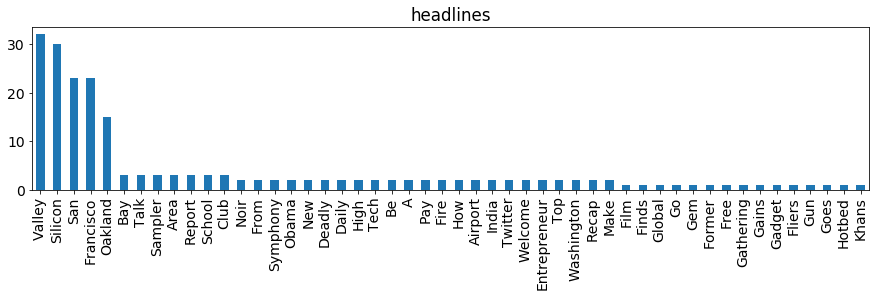

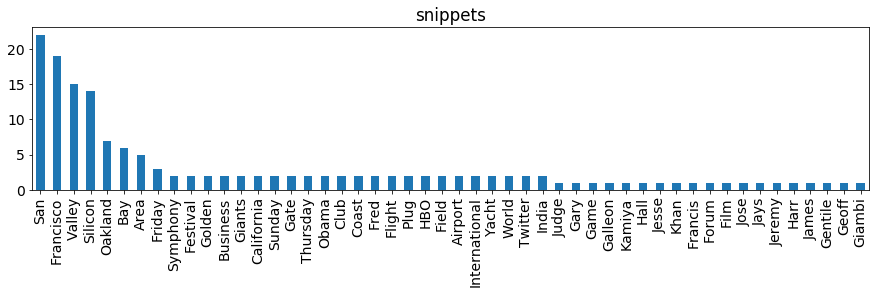

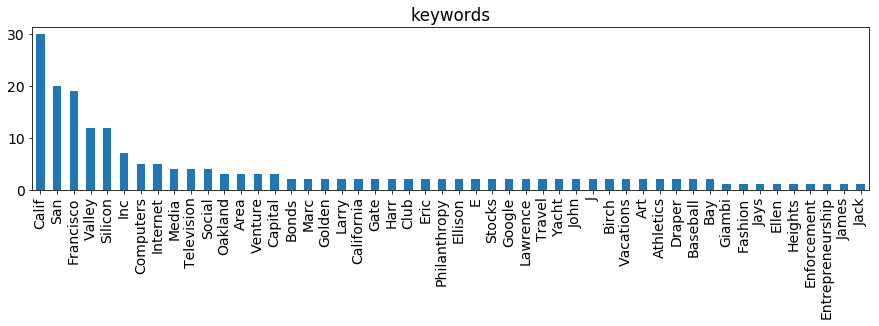

In [6]:
for source in reader_sf.text_sources.keys():
    reader_sf.plot_top_words(df=reader_sf.df_from_text([source]), n=50, title=source, 
                      pos_list=reader_sf.pos['include'], exclude=False, print_tuple=False)

### Searching and printing

In [7]:
reader_sf.get_single_entity(1)

HEADLINE: Living In Bernal Heights, San Francisco
SNIPPET: Property values have rapidly appreciated in this San Francisco neighborhood, but there’s still a communal vibe — and a coyote.
KEYWORD: San Francisco (Calif) | Real Estate and Housing (Residential) | Bernal Heights (San Francisco, Calif)
DATETIME: 2016-12-10T10:00:34+0000



In [8]:
reader_sf.search('Media')

HEADLINE: Davos Gadget Gets a Silicon Valley Tweak
SNIPPET: Even the hackers show up in Davos. On Thursday, Blake Krikorian, co-founder of Sling Media, the Silicon Valley maker of the Slingbox, was ecstatic that he had managed to outfox the World Economic Forum organizers. He managed to defeat the security...
KEYWORD: 
DATETIME: 2007-01-25T11:20:36Z

HEADLINE: Daily Report: From Lemonade Stand to Twitter’s I.P.O., a 10-Year-Old’s Journey to Silicon Valley
SNIPPET: Vivienne Harr became an Internet sensation for a lemonade stand she started to end child slavery. Now, she has a crowdfunding app that’s funded by Twitter and Google luminaries. Hers is a story of the power of networking in the social media age.
KEYWORD: Dorsey, Jack | Harr, Eric | Harr, Vivienne | Stone, Biz | Tan, Chade-Meng | Make a Stand Inc | Mobile Applications | Philanthropy | Social Media
DATETIME: 2014-10-08T08:09:42Z

HEADLINE: Daily Report: Anonymous Social App Offers a Hotbed of Silicon Valley Gossip
SNIPPET: Post

### Build word list
This method will return a list of words of the specified parts of speech

In [9]:
text_words = reader_sf.get_words(source_list=['headlines', 'snippets'], pos_list=None, exclude=False)

print('%d total words, %d unique words' % (len(text_words), len(set(text_words))))

2300 total words, 1139 unique words


## Make wordcloud image

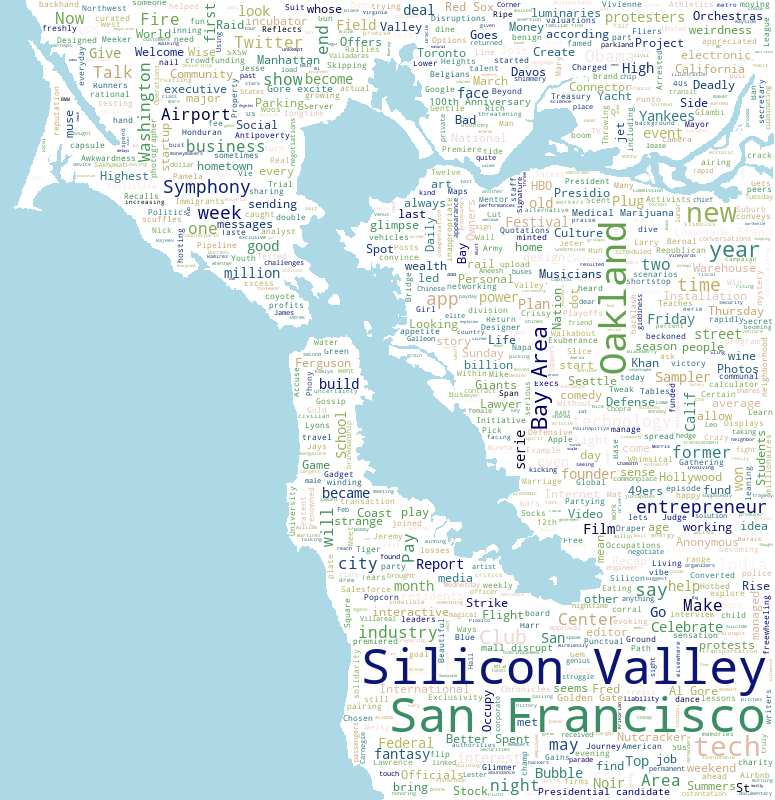

In [10]:
# get list of text sources
text_list = reader_sf.build_list_from_sources(source_list=['headlines','snippets'])

# make image and wordcloud
wa= WordArt()
image = wa.create_mask_image('source images/Location_Map_San_Francisco_Bay_Area_edited.gif')

wa.make_wordcloud(text=text_list, image=image,
               filename="final images/sf_bay.png", 
               colormap='gist_earth', background='lightblue', 
               max_size=(800,800))

# Twitter

## Define authorization

In [11]:
auth = OAuth1(client_key=twitter_auth_dict['client_key'],
                client_secret=twitter_auth_dict['client_secret'],
                resource_owner_key=twitter_auth_dict['resource_owner_key'],
                resource_owner_secret=twitter_auth_dict['resource_owner_secret'])

## Get tweets

### By search term

In [12]:
reader_twitter = TwitterReader(auth)
reader_twitter.get_search_term(search='Oakland', tweet_limit=200, verbose=True, recent=True)

Got 200 tweets from 2018-05-27 20:38:28 to 2018-05-27 20:59:52, allowance now 178 requests


### By geolocation
Note this doesn't always work reliably, consider using the `get_recent_tweets()` method instead

In [13]:
reader_twitter.get_search_term(geo='37.817941,-122.352714,20mi', tweet_limit=200, verbose=True)

Only got 99 results
Got 99 tweets from 2018-05-27 20:59:28 to 2018-05-27 20:59:54, allowance now 177 requests


### Filter realtime tweets by location
Note these take a while to load so limits should be set lower

In [14]:
reader_twitter_rt = TwitterReader(auth)
reader_twitter_rt.get_recent_tweets(location_box='-122.75,36.8,-121.75,37.8', tweet_limit=10, verbose=True)

Got 10 tweets from 2018-05-27 21:00:13 to 2018-05-27 21:00:23, allowance now 177 requests


## Methods

### Testing words from different types of sources
This example only prints proper nouns. Base class dict `WordsAPI.pos` contains different types of parts of speech to use

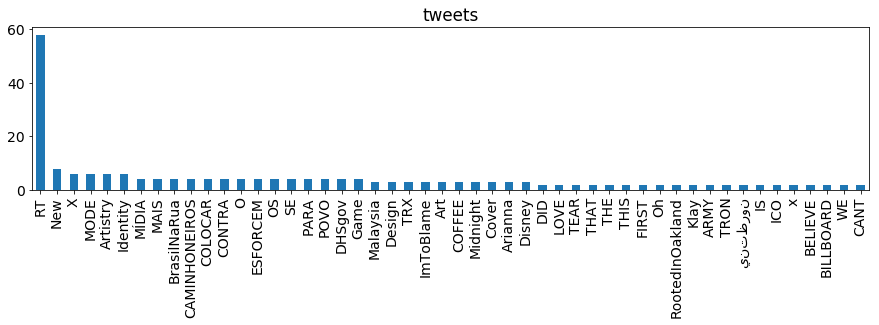

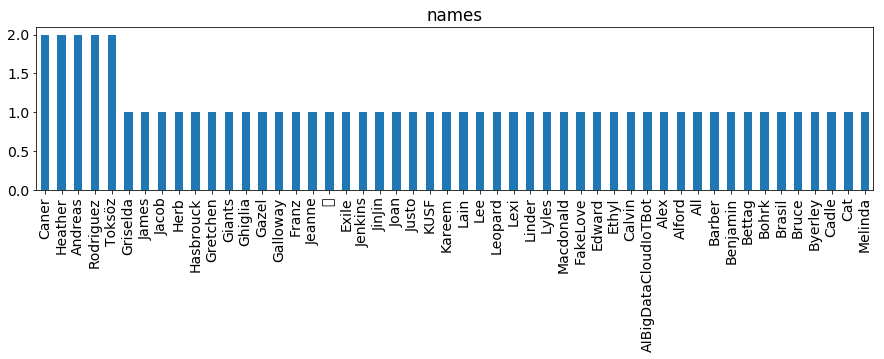

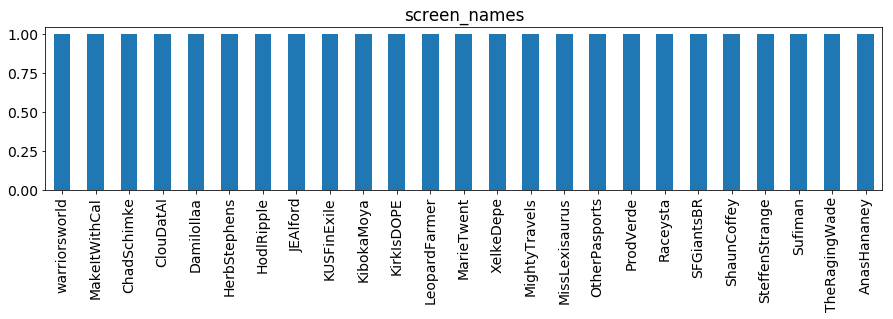

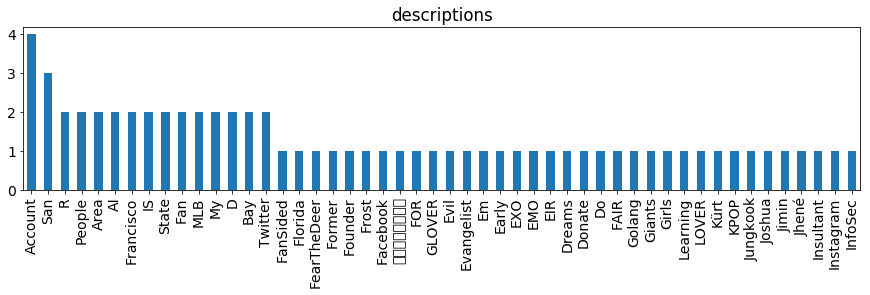

In [15]:
for source in reader_twitter.text_sources.keys():
    reader_twitter.plot_top_words(df=reader_twitter.df_from_text([source]), n=50, title=source, 
                      pos_list=reader_twitter.pos['include'], exclude=False, print_tuple=False)

### Searching and printing

In [16]:
reader_twitter.get_single_entity(1)

TWEET: Snapchat definitely plummeting but still overvalued https://t.co/LTIlgRPXMP
NAME: Yannik🎒
SCREEN_NAME: YEckart1
DESCRIPTION: Florida born, but 510 is home. living life and chasing dreams.Not perfect, but always staying true to myself. .#F2G #TMC #dubnation |19| cvhs '17| 🏀⚾️🇩🇪🇺🇸
DATETIME: 2018-05-27 20:59:54



In [17]:
reader_twitter.search('Warriors')

TWEET: RT @Nai_Roy: Klay x Game 6’s https://t.co/bUsKgyqaRW
NAME: warriorsworld
SCREEN_NAME: warriorsworld
DESCRIPTION: Longest running independent site covering the Golden State Warriors.
DATETIME: 2018-05-27 20:59:37



### Build word list
This method will return a list of words of the specified parts of speech

In [18]:
text_words = reader_twitter.get_words(source_list=['tweets'], pos_list=None, exclude=False)

print('%d total words, %d unique words' % (len(text_words), len(set(text_words))))

1306 total words, 675 unique words


## Make wordcloud

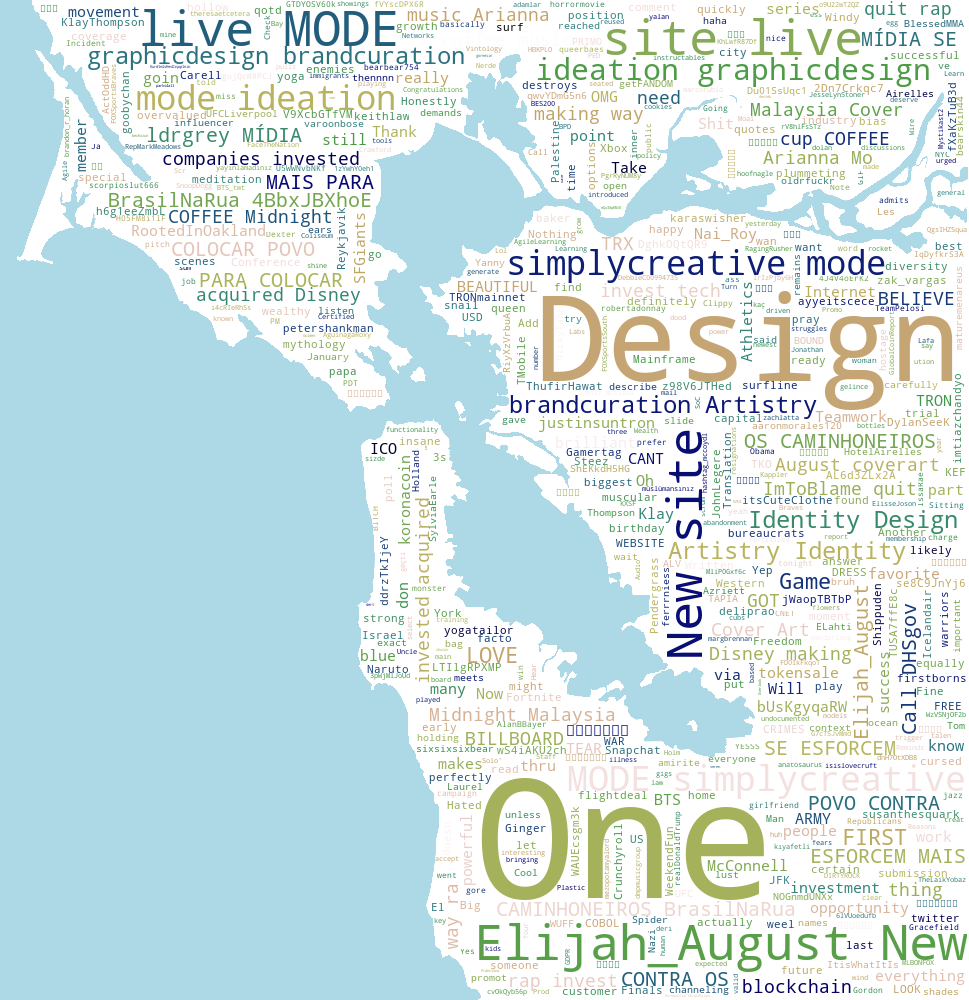

In [19]:
# set max size for ok display in notebook
max_size = (1000,1000)
# get list of text sources
text_list = reader_twitter.build_list_from_sources(source_list=['tweets'])

# make image and wordcloud
wa= WordArt()
image = wa.create_mask_image('source images/Location_Map_San_Francisco_Bay_Area_edited.gif')

wa.make_wordcloud(text=text_list, image=image,
               filename="final images/sf_bay_twitter.png", 
               colormap='gist_earth', background='lightblue',
               additional_stopwords=['https', 'co', 'amp', 'RT'], 
               reset_stopwords=False, max_size=max_size)


# More wordclouds

Request failed, only got 30 docs
Got 30 docs, from 1863-11-05T00:03:58Z to 2014-08-25T04:32:27Z


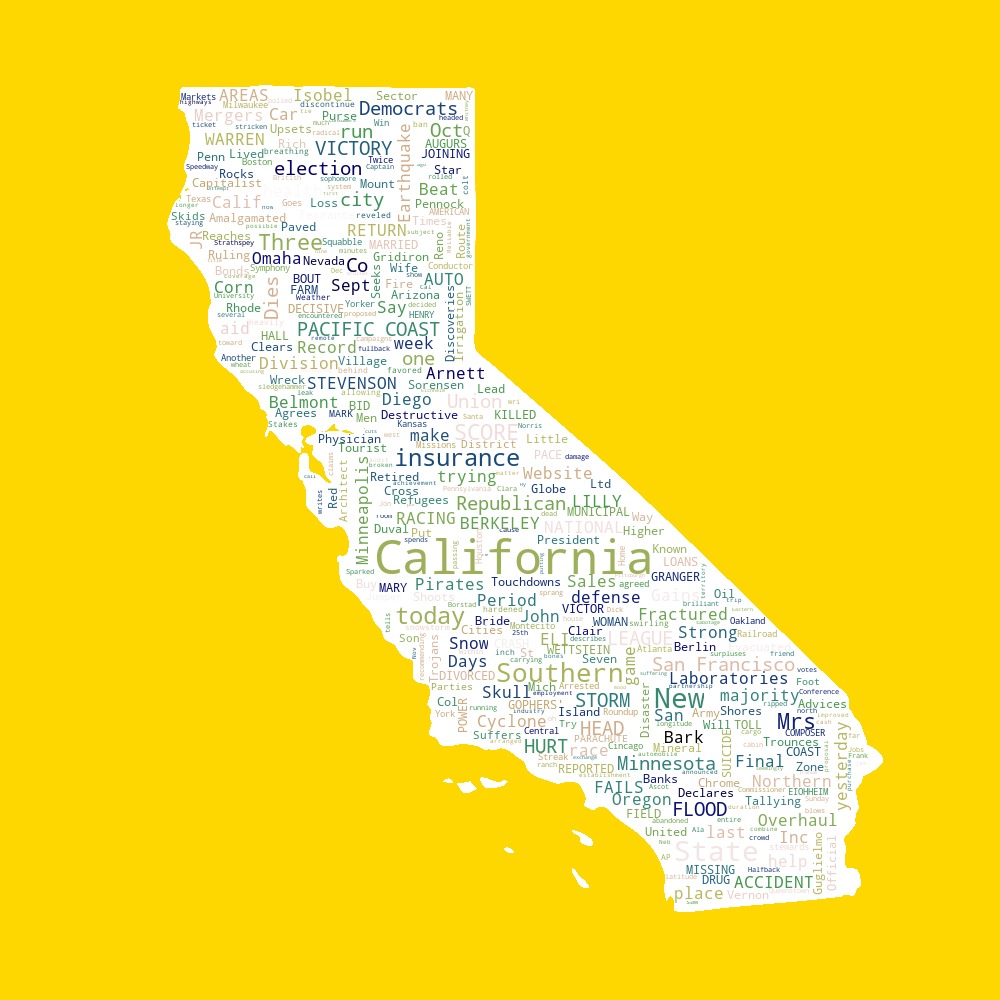

In [20]:
# california
reader_ca = NYTReader(nyt_key)
reader_ca.get_search_term(search='headline:("California")', 
                             article_limit=200,
                             verbose=True)

# get list of text sources
text_list = reader_ca.build_list_from_sources(source_list=['headlines','snippets'])

# make image and wordcloud
wa= WordArt()
image = wa.create_mask_image('source images/kalifornien_schwarz.png', transparency=True)

wa.make_wordcloud(text=text_list, image=image,
               filename="final images/ca.png", 
               colormap='gist_earth', background='gold',
               max_size=max_size)

Request failed, only got 120 docs
Got 120 docs, from 2001-06-26T00:00:00Z to 2017-09-09T21:36:13+0000


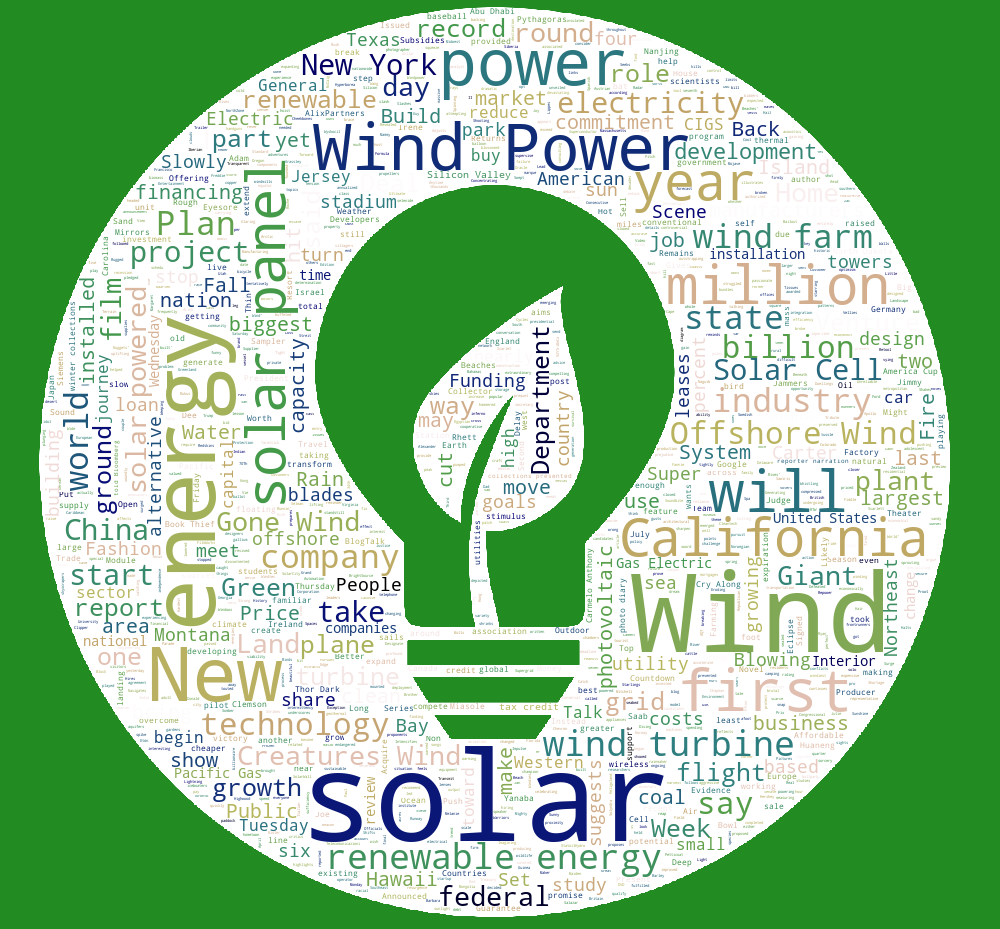

In [21]:
# renewable energy
reader_green = NYTReader(nyt_key)
reader_green.get_search_term(search='headline:("Solar", "Wind", "Renewable")', 
                                begin_date='20010101',
                                article_limit=200,
                                verbose=True)

# get list of text sources
text_list = reader_green.build_list_from_sources(source_list=['headlines','snippets'])

# make image and wordcloud
wa= WordArt()
image = wa.create_mask_image('source images/Renewable-Energy-Consultants.png', transparency=True)

wa.make_wordcloud(text=text_list, image=image,
               filename="final images/green.png",
               colormap='gist_earth', background='forestgreen', 
               max_size=max_size)


Request failed, only got 10 docs
Got 10 docs, from 1950-01-16T00:00:00Z to 2015-01-01T07:11:58Z


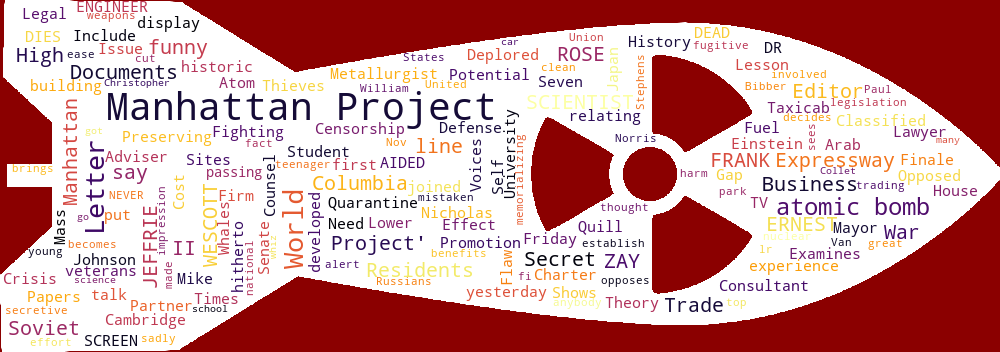

In [22]:
# manhattan project
reader_bomb = NYTReader(nyt_key)
reader_bomb.get_search_term(search='headline:("Manhattan Project")', 
                            article_limit=100,
                            verbose=True)

# get list of text sources
text_list = reader_bomb.build_list_from_sources(source_list=['headlines','snippets'])

# make image and wordcloud
wa= WordArt()
image = wa.create_mask_image('source images/ABomb.png', transparency=True, rotate=270)

wa.make_wordcloud(text=text_list, image=image,
               filename="final images/bomb.png",
               colormap='inferno', background='darkred', 
               max_size=max_size)

Request failed, only got 100 docs
Got 100 docs, from 1902-11-05T00:00:00Z to 2010-08-18T09:58:13Z


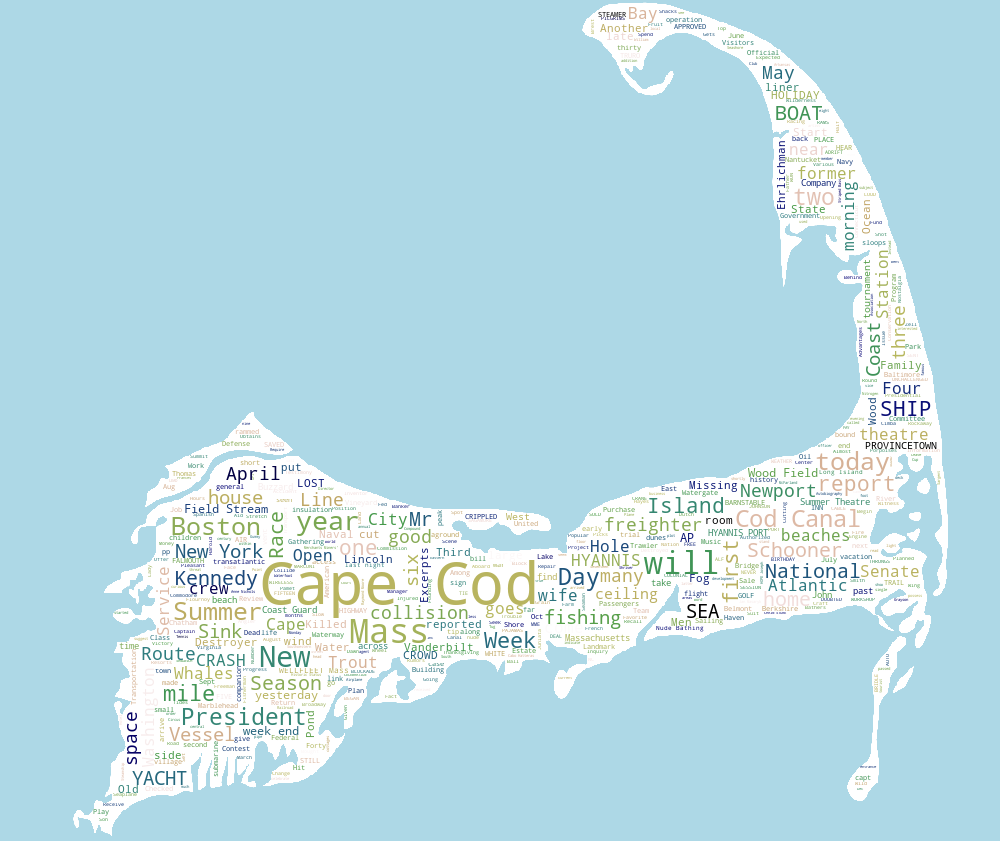

In [23]:
# cape cod
reader_cc = NYTReader(nyt_key)
reader_cc.get_search_term(search='headline:("Cape Cod")', 
                             begin_date='19010101',
                             article_limit=200,
                             verbose=True)

# get list of text sources
text_list = reader_cc.build_list_from_sources(source_list=['headlines','snippets'])

# make image and wordcloud
wa= WordArt()
image = wa.create_mask_image('source images/capecod.PNG')

wa.make_wordcloud(text=text_list, image=image,
               filename="final images/capecod.png", 
               colormap='gist_earth', background='lightblue', 
               max_size=max_size)

Got 300 tweets from 2018-05-18 02:51:20 to 2018-05-27 17:10:11, allowance now 174 requests


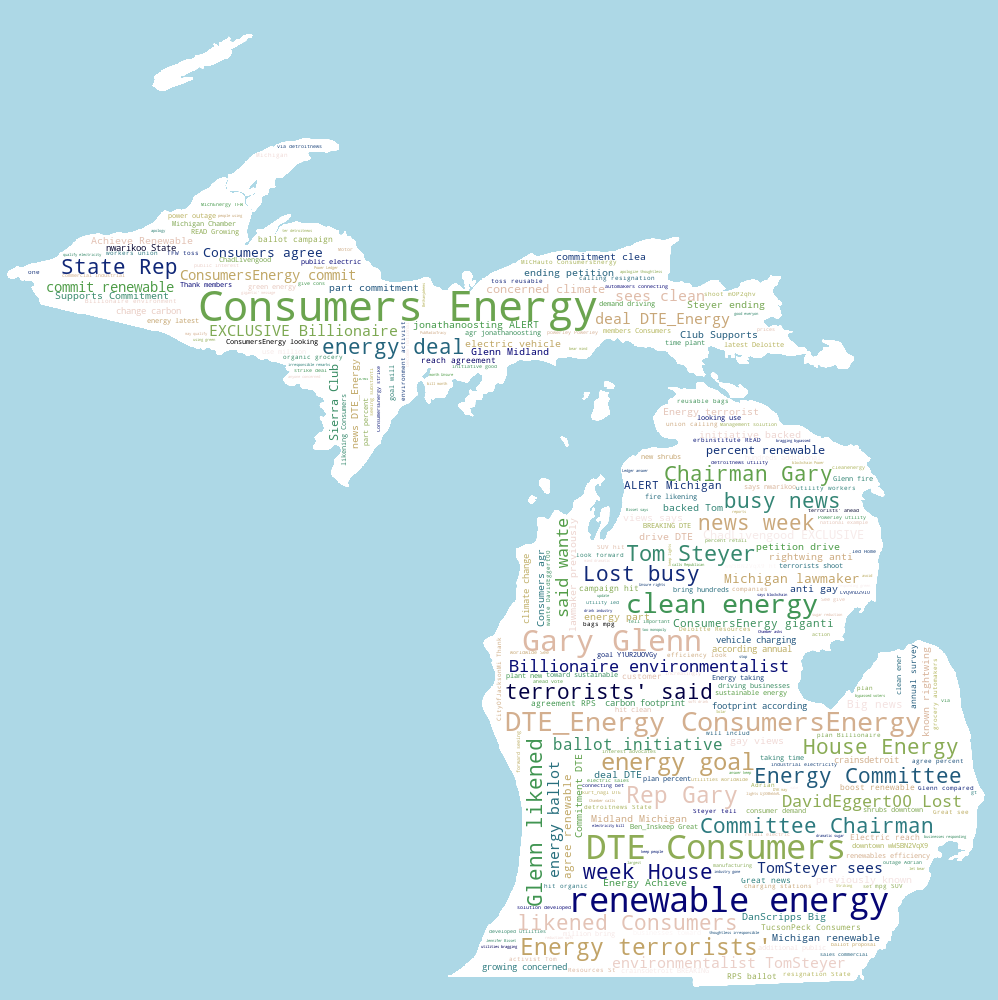

In [24]:
# utilities in mi
reader_mi = TwitterReader(auth)
reader_mi.get_search_term(search=['Consumers Energy', 'ConsumersEnergy', 'CE', 'DTE'], 
                          geo='43.900689,-84.782134,300mi',
                          tweet_limit=300,
                          verbose=True)

# get list of text sources
text_list = reader_mi.build_list_from_sources(source_list=['tweets'])

# make image and wordcloud
wa= WordArt()
image = wa.create_mask_image('source images/Michigan.PNG')

wa.make_wordcloud(text=text_list, image=image,
                  filename="final images/utilities.png",
                  colormap='gist_earth', background='lightblue',
                  additional_stopwords=['https', 'co', 'amp', 'RT'],
                  max_size=max_size)


# Help and introspection

## NYTReader

In [25]:
help(reader_sf)
print('Data: %s' % ', '.join([key for key in reader_sf.__dict__.keys()]))

Help on NYTReader in module __main__ object:

class NYTReader(WordsAPI)
 |  Reads NYT article API
 |  
 |  Method resolution order:
 |      NYTReader
 |      WordsAPI
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  __init__(self, key=None)
 |      Initialize self.  See help(type(self)) for accurate signature.
 |  
 |  get_search_term(self, search=None, article_limit=50, begin_date=None, end_date=None, verbose=False)
 |      Fetches results for a search string and/or a date range of string format YYYMMDD
 |  
 |  ----------------------------------------------------------------------
 |  Methods inherited from WordsAPI:
 |  
 |  build_list_from_sources(self, source_list)
 |      strings together all entities from source list
 |  
 |  df_from_text(self, source_list)
 |      Creates df from a text source
 |  
 |  get_single_entity(self, i)
 |      Prints a representation of the complete ith source
 |  
 |  get_words(self, source_list, pos_list=None, exclude=False)
 |      R

## TwitterReader

In [26]:
help(reader_twitter)
print('Data: %s' % ', '.join([key for key in reader_twitter.__dict__.keys()]))

Help on TwitterReader in module __main__ object:

class TwitterReader(WordsAPI)
 |  Reads NYT article API
 |  
 |  Method resolution order:
 |      TwitterReader
 |      WordsAPI
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  __init__(self, auth=None)
 |      Initialize self.  See help(type(self)) for accurate signature.
 |  
 |  get_recent_tweets(self, tweet_limit=200, location_box=None, verbose=False)
 |      Fetches recent tweets, with optional location defined as LON,LAT,LON,LAT 
 |      with SW corner coming first
 |  
 |  get_search_term(self, search='', tweet_limit=200, geo=None, verbose=False, recent=False)
 |      Fetches results for a search string and optional geocode
 |      of string format LAT,LON,RADIUSmi
 |  
 |  ----------------------------------------------------------------------
 |  Methods inherited from WordsAPI:
 |  
 |  build_list_from_sources(self, source_list)
 |      strings together all entities from source list
 |  
 |  df_from_text(self, s

## WordArt

In [33]:
help(wa)

Help on class WordArt in module __main__:

class WordArt(builtins.object)
 |  Class for creating word art images
 |  
 |  Methods defined here:
 |  
 |  create_mask_image(self, image_location, invert=False, rotate=0, transparency=False, max_size=None)
 |      Creates a proper image with white areas for masking
 |  
 |  make_wordcloud(self, text, filename, image=None, colormap='viridis', background='white', max_words=4000, additional_stopwords=None, desktop=False, max_size=(1920, 1080), reset_stopwords=False)
 |      Makes a wordcloud, with added features like background fill and desktop modes.
 |      Can optionally add additional stopwords (words to keep out of image), or 
 |      reset the standard stopwords and define them all yourself.
 |  
 |  ----------------------------------------------------------------------
 |  Data descriptors defined here:
 |  
 |  __dict__
 |      dictionary for instance variables (if defined)
 |  
 |  __weakref__
 |      list of weak references to the ob